<a href="https://colab.research.google.com/github/zhibinz2/Neural-Networks-and-Machine-Learning/blob/master/ZHIBIN_Final_Project_Leave_One_Out_4_fcn_single_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
!wget https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/AwakeSamples.npy
AwakeSamples=np.load('AwakeSamples.npy')
!wget https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/SedatedSamples.npy
SedatedSamples=np.load('SedatedSamples.npy')

import tqdm

import torch
from torch import optim
from torch import nn


import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision import models, transforms
from torch.autograd import Variable

import pandas as pd
from PIL import Image
import requests
import io
import random, time, sys
from collections import namedtuple

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

--2020-12-09 06:40:20--  https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/AwakeSamples.npy
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zhibinz2/Neural-Networks-and-Machine-Learning/master/AwakeSamples.npy [following]
--2020-12-09 06:40:21--  https://raw.githubusercontent.com/zhibinz2/Neural-Networks-and-Machine-Learning/master/AwakeSamples.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13249728 (13M) [application/octet-stream]
Saving to: ‘AwakeSamples.npy’

AwakeSamples.npy    100%[===================>]  12.64M  60.4MB/s    in 0.2s    

2020-12-09 06:40:21 (60.

In [4]:
# Conbine two categories of samples into data
data=np.concatenate((AwakeSamples,SedatedSamples),axis=0)

In [5]:
# Add one dimension, needed for both single layer FCN and convolutional network
data=np.expand_dims(data, axis=1)

In [6]:
# only for single layer FCN
import numpy.matlib
A=numpy.matlib.repmat(np.array([1, 0]),200,1)
B=numpy.matlib.repmat(np.array([0, 1]),200,1)
targets=np.concatenate((A,B),axis=0)

In [7]:
# leave one out
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
loo.get_n_splits(data)

400

In [8]:
from torch.utils.data import Dataset
class MyTrainingDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.root=root
        self.transform=transform
        self.target_transform=target_transform
        self.data=np.load(self.root[0])
        self.targets=np.load(self.root[1])
        
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        sample=self.data[idx] 
        target=self.targets[idx]
        
        if self.transform:
            sample=self.transform(sample)
        if self.target_transform:
            target=self.target_transform(target)
            
        return sample, target

In [10]:
net = torch.nn.Sequential(torch.nn.Linear(8281, 100),torch.nn.Sigmoid(),torch.nn.Linear(100,2),
                                  torch.nn.Sigmoid())

In [11]:
mse_loss = torch.nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [12]:
def train_step(x, t, net, opt_fn, loss_fn):
    y = net(x)
    loss = loss_fn(y, t)
    loss.backward()
    opt_fn.step()
    opt_fn.zero_grad()
    return loss

In [25]:
batch=100

In [26]:
acc_hist_train = []
acc_hist_test = []

for train_index, test_index in loo.split(data):
  #print("TRAIN:", train_index, "TEST:", test_index)
  train_data, test_data = data[train_index], data[test_index]
  train_targets, test_targets = targets[train_index], targets[test_index]
  #print(train_data, test_data, train_targets, test_targets)

  np.save('train_data.npy',train_data)
  np.save('train_targets.npy',train_targets)
  train_set=MyTrainingDataset(root=['train_data.npy', 'train_targets.npy'])

  np.save('test_data.npy',test_data)
  np.save('test_targets.npy',test_targets)
  test_set=MyTrainingDataset(root=['test_data.npy', 'test_targets.npy'])

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch, shuffle=False)

  # 4_fcn_single_layer
  x,t = next(iter(train_loader))
  train_step(x.float().view(-1,8281), t.float(), net, opt, mse_loss)

  # Make prediction
  for x,t in iter(train_loader):
    y = net(x.float().view(-1,8281))

  # Calculate accuracy
  torch.mean((t.argmax(1) == y.argmax(1)).float())

  # Train the network over multiple epochs
  for epoch in range(5):
    acc_batch = []
    for x,t in iter(train_loader):
      loss_ = train_step(x.float().view(-1,8281), t.float(), net, opt, mse_loss)
      y = net(x.float().view(-1,8281))
      acc_batch.append(torch.mean((t.argmax(1) == y.argmax(1)).float()))
    acc_hist_train.append(torch.mean(torch.FloatTensor(acc_batch)))
    print(loss_)

    acc_batch = []
    for x,t in iter(test_loader):
      y = net(x.float().view(-1,8281))
      acc_batch.append(torch.mean((t.argmax(1) == y.argmax(1)).float()))
    acc_hist_test.append(torch.mean(torch.FloatTensor(acc_batch)))

  acc_hist_train
  acc_hist_test



tensor(9.8315e-12, grad_fn=<MseLossBackward>)
tensor(9.6457e-12, grad_fn=<MseLossBackward>)
tensor(1.3554e-11, grad_fn=<MseLossBackward>)
tensor(9.6485e-12, grad_fn=<MseLossBackward>)
tensor(8.9082e-12, grad_fn=<MseLossBackward>)
tensor(1.3531e-11, grad_fn=<MseLossBackward>)
tensor(5.8102e-12, grad_fn=<MseLossBackward>)
tensor(1.0813e-11, grad_fn=<MseLossBackward>)
tensor(9.3605e-12, grad_fn=<MseLossBackward>)
tensor(7.7895e-12, grad_fn=<MseLossBackward>)
tensor(8.3246e-12, grad_fn=<MseLossBackward>)
tensor(1.0461e-11, grad_fn=<MseLossBackward>)
tensor(1.2691e-11, grad_fn=<MseLossBackward>)
tensor(7.0221e-12, grad_fn=<MseLossBackward>)
tensor(1.2080e-11, grad_fn=<MseLossBackward>)
tensor(1.1009e-11, grad_fn=<MseLossBackward>)
tensor(9.3435e-12, grad_fn=<MseLossBackward>)
tensor(9.5412e-12, grad_fn=<MseLossBackward>)
tensor(6.9300e-12, grad_fn=<MseLossBackward>)
tensor(1.0587e-11, grad_fn=<MseLossBackward>)
tensor(1.1554e-11, grad_fn=<MseLossBackward>)
tensor(9.5813e-12, grad_fn=<MseLos

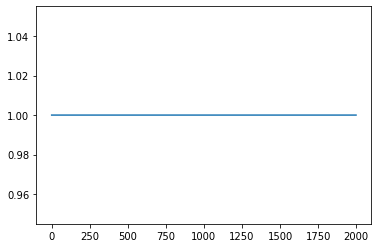

In [27]:
plt.plot(acc_hist_train)


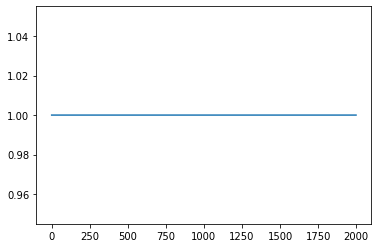

In [28]:
plt.plot(acc_hist_test)


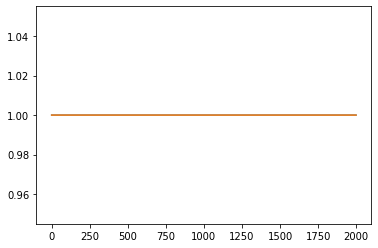

In [29]:
plt.plot(acc_hist_train)
plt.plot(acc_hist_test)